# 📊 Data Analyst Agent using LLaMA-4 Maverick


In [1]:
!pip install together python-dotenv pandas matplotlib seaborn openpyxl python-docx PyMuPDF pillow pytesseract


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os
from dotenv import load_dotenv
from together import Together
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fitz  # PyMuPDF
from docx import Document
from PIL import Image
import pytesseract
import io


client = Together(api_key="4947ed321035e7b7f6483ccc4d653dd478f3eaa531691b36975b69e8f19bb36c")

In [6]:
def llama_ask(prompt, system_prompt="You are a helpful data analyst."):
    response = client.chat.completions.create(
        model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
        max_tokens=1024,
        temperature=0.7,
        top_p=0.9
    )
    return response.choices[0].message.content

In [7]:
def load_file(file):
    if file.name.endswith('.csv'):
        return pd.read_csv(file)
    elif file.name.endswith('.xlsx'):
        return pd.read_excel(file)
    elif file.name.endswith('.txt'):
        return file.read().decode('utf-8')
    elif file.name.endswith('.docx'):
        doc = Document(file)
        return "\n".join([para.text for para in doc.paragraphs])
    elif file.name.endswith('.pdf'):
        with fitz.open(stream=file.read(), filetype='pdf') as doc:
            return "\n".join([page.get_text() for page in doc])
    elif file.name.endswith(('.png', '.jpg', '.jpeg')):
        img = Image.open(file)
        return pytesseract.image_to_string(img)
    else:
        return "Unsupported file format"

In [8]:
def analyze_dataframe(df):
    description = df.describe(include='all').to_string()
    missing = df.isnull().sum().to_string()
    types = df.dtypes.to_string()
    return f"Data Types:\n{types}\n\nMissing Values:\n{missing}\n\nSummary Stats:\n{description}"

In [9]:
def plot_column(df, column):
    plt.figure(figsize=(8,4))
    if df[column].dtype == 'object':
        sns.countplot(data=df, x=column)
    else:
        sns.histplot(data=df, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [10]:
def answer_question(df, question):
    if not isinstance(df, pd.DataFrame):
        return "Uploaded file is not a dataframe. Can't analyze."

    sample = df.head(5).to_csv(index=False)
    prompt = f"""Here's a sample from the dataset:
{sample}

User Question: {question}
"""
    return llama_ask(prompt)

✅ DataFrame Preview:
          Order ID Order Date Ship Date       Ship Mode Customer ID  \
0  CA-2016-152156    11/8/16  11/11/16    Second Class    CG-12520   
1  CA-2016-152156    11/8/16  11/11/16    Second Class    CG-12520   
2  CA-2016-138688    6/12/16   6/16/16    Second Class    DV-13045   
3  US-2015-108966   10/11/15  10/18/15  Standard Class    SO-20335   
4  US-2015-108966   10/11/15  10/18/15  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category Sub-Category  \
0        42420  South 

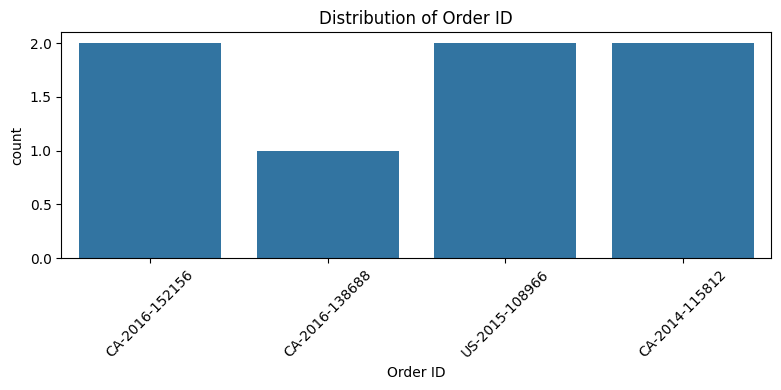


❓ Q&A:
 To identify trends in the provided dataset, I will analyze the given sample data. The dataset appears to be related to sales and customer information.

### Initial Observations

1. **Data Variety**: The dataset includes a wide range of information such as order details (Order ID, Order Date, Ship Date, Ship Mode), customer information (Customer ID, Customer Name, Segment), geographical data (Country, City, State, Postal Code, Region), product details (Product ID, Category, Sub-Category, Product Name), and sales data (Sales, Quantity, Discount, Profit).

2. **Sales and Profitability**: The sales and profitability can be analyzed by looking at the 'Sales' and 'Profit' columns. There's a significant variation in both, indicating diverse product pricing and profitability.

3. **Geographical Distribution**: The data includes entries from different states and regions within the United States, indicating a national customer base. The 'Region' column categorizes the data into West, So

In [12]:
# Example usage
with open("sample_superstore.csv", "rb") as f:
    file = io.BytesIO(f.read())
    file.name = "sample_superstore.csv"

loaded = load_file(file)
if isinstance(loaded, pd.DataFrame):
    df = loaded
    print("✅ DataFrame Preview:\n", df.head())
    print("\n📊 Analysis:\n", analyze_dataframe(df))
    plot_column(df, df.columns[0])
    print("\n❓ Q&A:\n", answer_question(df, "What trends can you see in this data?"))